In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/modeling_data.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,Date_Time,BO,BH,BL,BC,1_mo,3_mo,6_mo,1_yr,2_yr,...,20_yr,federal funds rate,retail sales,core retail sales,PPI m/m,unemployment rate,main refinancing rate,CPI m/m,Core CPI m/m,Prelim GDP q/q
0,2005-05-02,1.285468,1.286136,1.284941,1.285476,2.68,2.93,3.19,3.34,3.64,...,4.61,0,0,0,0,0,0,0,0,0
1,2005-05-03,1.286334,1.287307,1.285568,1.286427,2.65,2.91,3.19,3.35,3.68,...,4.60,0,0,0,0,0,0,0,0,0
2,2005-05-04,1.294374,1.295348,1.293517,1.294647,2.59,2.87,3.17,3.32,3.63,...,4.64,0,0,0,0,0,0,0,0,0
3,2005-05-05,1.295118,1.295977,1.294439,1.295139,2.60,2.81,3.14,3.29,3.58,...,4.64,0,0,0,0,0,0,0,0,0
4,2005-05-06,1.289243,1.289763,1.288157,1.288693,2.64,2.87,3.19,3.37,3.73,...,4.69,0,0,0,0,0,0,0,0,0


In [3]:
df.dtypes

Date_Time                 object
BO                       float64
BH                       float64
BL                       float64
BC                       float64
1_mo                     float64
3_mo                     float64
6_mo                     float64
1_yr                     float64
2_yr                     float64
3_yr                     float64
5_yr                     float64
7_yr                     float64
10_yr                    float64
20_yr                    float64
federal funds rate         int64
retail sales               int64
core retail sales          int64
PPI m/m                    int64
unemployment rate          int64
main refinancing rate      int64
CPI m/m                    int64
Core CPI m/m               int64
Prelim GDP q/q             int64
dtype: object

In [4]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
df.set_index('Date_Time', inplace=True)
df.sort_index(inplace=True)
df.head()

,BO,BH,BL,BC,1_mo,3_mo,6_mo,1_yr,2_yr,3_yr,...,20_yr,federal funds rate,retail sales,core retail sales,PPI m/m,unemployment rate,main refinancing rate,CPI m/m,Core CPI m/m,Prelim GDP q/q
Date_Time,,,,,,,,,,,,,,,,,,,,,
2005-05-02,1.285468,1.286136,1.284941,1.285476,2.68,2.93,3.19,3.34,3.64,3.71,...,4.61,0,0,0,0,0,0,0,0,0
2005-05-03,1.286334,1.287307,1.285568,1.286427,2.65,2.91,3.19,3.35,3.68,3.73,...,4.60,0,0,0,0,0,0,0,0,0
2005-05-04,1.294374,1.295348,1.293517,1.294647,2.59,2.87,3.17,3.32,3.63,3.70,...,4.64,0,0,0,0,0,0,0,0,0
2005-05-05,1.295118,1.295977,1.294439,1.295139,2.60,2.81,3.14,3.29,3.58,3.65,...,4.64,0,0,0,0,0,0,0,0,0
2005-05-06,1.289243,1.289763,1.288157,1.288693,2.64,2.87,3.19,3.37,3.73,3.80,...,4.69,0,0,0,0,0,0,0,0,0


In [5]:
df.shape

(3746, 23)

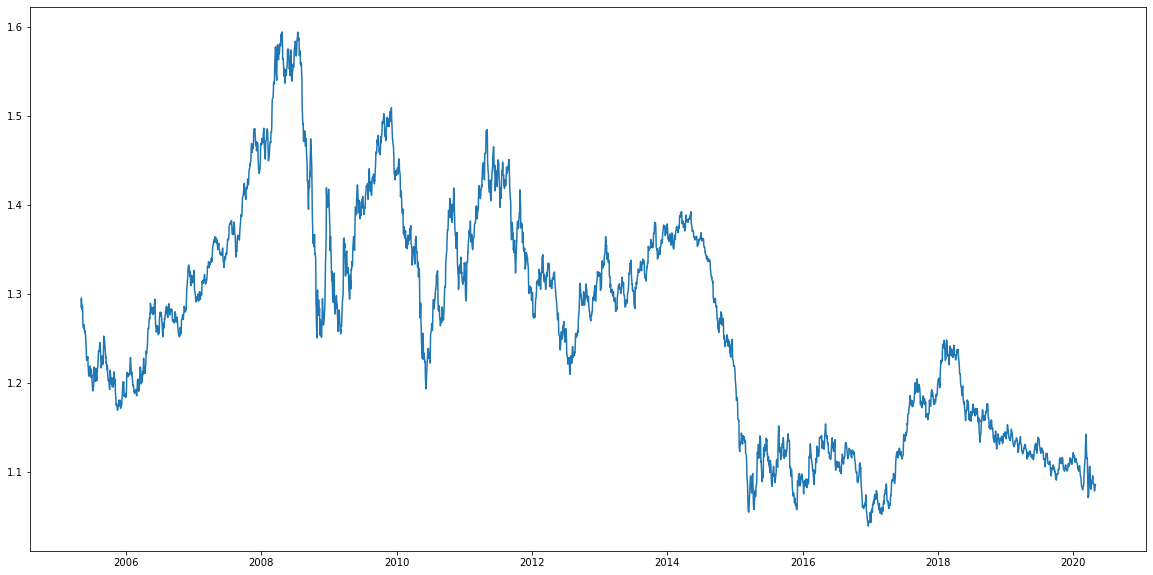

In [6]:
plt.figure(figsize=(20,10))
plt.plot(df['BO'])

In [7]:
df.isnull().sum()

BO                       0
BH                       0
BL                       0
BC                       0
1_mo                     0
3_mo                     0
6_mo                     0
1_yr                     0
2_yr                     0
3_yr                     0
5_yr                     0
7_yr                     0
10_yr                    0
20_yr                    0
federal funds rate       0
retail sales             0
core retail sales        0
PPI m/m                  0
unemployment rate        0
main refinancing rate    0
CPI m/m                  0
Core CPI m/m             0
Prelim GDP q/q           0
dtype: int64

In [8]:
Bid_Open = df[['BO']]
Bid_Open.head()

,BO
Date_Time,
2005-05-02,1.285468
2005-05-03,1.286334
2005-05-04,1.294374
2005-05-05,1.295118
2005-05-06,1.289243


In [9]:
df_shifted = df.shift()
df_shifted.drop(columns=['BO'], inplace=True)
df_shifted.head()

,BH,BL,BC,1_mo,3_mo,6_mo,1_yr,2_yr,3_yr,5_yr,...,20_yr,federal funds rate,retail sales,core retail sales,PPI m/m,unemployment rate,main refinancing rate,CPI m/m,Core CPI m/m,Prelim GDP q/q
Date_Time,,,,,,,,,,,,,,,,,,,,,
2005-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-05-03,1.286136,1.284941,1.285476,2.68,2.93,3.19,3.34,3.64,3.71,3.88,...,4.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-05-04,1.287307,1.285568,1.286427,2.65,2.91,3.19,3.35,3.68,3.73,3.90,...,4.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-05-05,1.295348,1.293517,1.294647,2.59,2.87,3.17,3.32,3.63,3.70,3.87,...,4.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-05-06,1.295977,1.294439,1.295139,2.60,2.81,3.14,3.29,3.58,3.65,3.82,...,4.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_merged = Bid_Open.merge(df_shifted, how='left', left_index=True, right_index=True)
df_merged.head()

,BO,BH,BL,BC,1_mo,3_mo,6_mo,1_yr,2_yr,3_yr,...,20_yr,federal funds rate,retail sales,core retail sales,PPI m/m,unemployment rate,main refinancing rate,CPI m/m,Core CPI m/m,Prelim GDP q/q
Date_Time,,,,,,,,,,,,,,,,,,,,,
2005-05-02,1.285468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-05-03,1.286334,1.286136,1.284941,1.285476,2.68,2.93,3.19,3.34,3.64,3.71,...,4.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-05-04,1.294374,1.287307,1.285568,1.286427,2.65,2.91,3.19,3.35,3.68,3.73,...,4.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-05-05,1.295118,1.295348,1.293517,1.294647,2.59,2.87,3.17,3.32,3.63,3.70,...,4.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-05-06,1.289243,1.295977,1.294439,1.295139,2.60,2.81,3.14,3.29,3.58,3.65,...,4.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_merged = df_merged.dropna()
df_merged.head()

,BO,BH,BL,BC,1_mo,3_mo,6_mo,1_yr,2_yr,3_yr,...,20_yr,federal funds rate,retail sales,core retail sales,PPI m/m,unemployment rate,main refinancing rate,CPI m/m,Core CPI m/m,Prelim GDP q/q
Date_Time,,,,,,,,,,,,,,,,,,,,,
2005-05-03,1.286334,1.286136,1.284941,1.285476,2.68,2.93,3.19,3.34,3.64,3.71,...,4.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-05-04,1.294374,1.287307,1.285568,1.286427,2.65,2.91,3.19,3.35,3.68,3.73,...,4.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-05-05,1.295118,1.295348,1.293517,1.294647,2.59,2.87,3.17,3.32,3.63,3.70,...,4.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-05-06,1.289243,1.295977,1.294439,1.295139,2.60,2.81,3.14,3.29,3.58,3.65,...,4.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-05-09,1.282314,1.289763,1.288157,1.288693,2.64,2.87,3.19,3.37,3.73,3.80,...,4.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df_merged.shape

(3745, 23)

In [14]:
df_merged = df_merged.drop(columns=['BC'])

### Preparing for Modeling

In [20]:
X = df_merged.drop(columns='BO')
y = df_merged['BO'].values

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, shuffle=False)

In [22]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [23]:
X.shape

(3745, 21)

### Modeling

In [54]:
def model_func(layer_one_neurons, layer_two_neurons, layer_three_neurons, dropout_percent_1, dropout_percent_2):
    print('layer_one', layer_one_neurons, 'layer_two', layer_two_neurons, 'layer_three', layer_three_neurons, 'drop_1', dropout_percent_1, 'drop_2', dropout_percent_2) # only to help troubleshoot
    model = Sequential()
    model.add(LSTM(layer_one_neurons, return_sequences=False, activation='relu', input_shape=(22, 1)))
    model.add(Dense(layer_two_neurons, activation='relu'))
    model.add(Dropout(dropout_percent_1))
    model.add(Dense(layer_three_neurons, activation='relu'))
    model.add(Dropout(dropout_percent_2))
    model.add(Dense(1, activation=None))
    model.compile(loss='mse', optimizer='adam')
    return model

nn = KerasRegressor(build_fn=model_func, batch_size=32, verbose=0)

<ipython-input-54-1a83dc556653>:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  nn = KerasRegressor(build_fn=model_func, batch_size=32, verbose=0)


In [12]:
params = {
    'epochs': [200],
    'layer_one_neurons': [64, 128],
    'layer_two_neurons': [64, 128],
    'layer_three_neurons': [32, 64, 128],
    'dropout_percent_1': [0, .25],
    'dropout_percent_2': [0, .25]
}
gs = GridSearchCV(nn, param_grid=params, scoring='neg_mean_absolute_percentage_error', refit=False, cv=5)
gs.fit(X_train_sc, y_train)
print(gs.best_score_) # <- negative mean squared error, ie the higher (less negative) the better
gs.best_params_

layer_one 64 layer_two 64 layer_three 32 drop_1 0 drop_2 0
layer_one 64 layer_two 64 layer_three 32 drop_1 0 drop_2 0
layer_one 64 layer_two 64 layer_three 32 drop_1 0 drop_2 0
layer_one 64 layer_two 64 layer_three 32 drop_1 0 drop_2 0
layer_one 64 layer_two 64 layer_three 32 drop_1 0 drop_2 0
layer_one 64 layer_two 128 layer_three 32 drop_1 0 drop_2 0
layer_one 64 layer_two 128 layer_three 32 drop_1 0 drop_2 0
layer_one 64 layer_two 128 layer_three 32 drop_1 0 drop_2 0
layer_one 64 layer_two 128 layer_three 32 drop_1 0 drop_2 0
layer_one 64 layer_two 128 layer_three 32 drop_1 0 drop_2 0
layer_one 64 layer_two 64 layer_three 64 drop_1 0 drop_2 0
layer_one 64 layer_two 64 layer_three 64 drop_1 0 drop_2 0
layer_one 64 layer_two 64 layer_three 64 drop_1 0 drop_2 0
layer_one 64 layer_two 64 layer_three 64 drop_1 0 drop_2 0
layer_one 64 layer_two 64 layer_three 64 drop_1 0 drop_2 0
layer_one 64 layer_two 128 layer_three 64 drop_1 0 drop_2 0
layer_one 64 layer_two 128 layer_three 64 drop_1 0

layer_one 64 layer_two 64 layer_three 64 drop_1 0.25 drop_2 0
layer_one 64 layer_two 64 layer_three 64 drop_1 0.25 drop_2 0
layer_one 64 layer_two 128 layer_three 64 drop_1 0.25 drop_2 0
layer_one 64 layer_two 128 layer_three 64 drop_1 0.25 drop_2 0
layer_one 64 layer_two 128 layer_three 64 drop_1 0.25 drop_2 0
layer_one 64 layer_two 128 layer_three 64 drop_1 0.25 drop_2 0
layer_one 64 layer_two 128 layer_three 64 drop_1 0.25 drop_2 0
layer_one 64 layer_two 64 layer_three 128 drop_1 0.25 drop_2 0
layer_one 64 layer_two 64 layer_three 128 drop_1 0.25 drop_2 0
layer_one 64 layer_two 64 layer_three 128 drop_1 0.25 drop_2 0
layer_one 64 layer_two 64 layer_three 128 drop_1 0.25 drop_2 0
layer_one 64 layer_two 64 layer_three 128 drop_1 0.25 drop_2 0
layer_one 64 layer_two 128 layer_three 128 drop_1 0.25 drop_2 0
layer_one 64 layer_two 128 layer_three 128 drop_1 0.25 drop_2 0
layer_one 64 layer_two 128 layer_three 128 drop_1 0.25 drop_2 0
layer_one 64 layer_two 128 layer_three 128 drop_1 0.25

{'dropout_percent_1': 0,
 'dropout_percent_2': 0,
 'epochs': 200,
 'layer_one_neurons': 128,
 'layer_three_neurons': 32,
 'layer_two_neurons': 128}

### Above GS took over 6 hours to perform with 3060 TI and Ryzen 7 5800x

### After GS, following model is made with best hyperparamters

In [24]:
model1 = Sequential()
model1.add(LSTM(128, return_sequences=False, activation='relu', input_shape=(21, 1)))
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0))
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0))
model1.add(Dense(1, activation=None))
model1.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_percentage_error'])

hist = model1.fit(X_train_sc, y_train, batch_size=32, epochs=200)

Epoch 1/200
100/100 [==============================] - 1s 5ms/step - loss: 0.2515 - mean_absolute_percentage_error: 25.4062
Epoch 2/200
100/100 [==============================] - 1s 5ms/step - loss: 0.0182 - mean_absolute_percentage_error: 8.8478
Epoch 3/200
100/100 [==============================] - 1s 5ms/step - loss: 0.0038 - mean_absolute_percentage_error: 3.3178
Epoch 4/200
100/100 [==============================] - 1s 5ms/step - loss: 0.0010 - mean_absolute_percentage_error: 1.7390
Epoch 5/200
100/100 [==============================] - 1s 5ms/step - loss: 6.8290e-04 - mean_absolute_percentage_error: 1.4847
Epoch 6/200
100/100 [==============================] - 1s 6ms/step - loss: 4.2116e-04 - mean_absolute_percentage_error: 1.0920
Epoch 7/200
100/100 [==============================] - 1s 6ms/step - loss: 3.7748e-04 - mean_absolute_percentage_error: 1.0820
Epoch 8/200
100/100 [==============================] - 1s 5ms/step - loss: 2.7270e-04 - mean_absolute_percentage_error: 0.9328

100/100 [==============================] - 1s 5ms/step - loss: 9.0647e-05 - mean_absolute_percentage_error: 0.5679
Epoch 65/200
100/100 [==============================] - 1s 5ms/step - loss: 1.1691e-04 - mean_absolute_percentage_error: 0.6532
Epoch 66/200
100/100 [==============================] - 1s 5ms/step - loss: 1.5876e-04 - mean_absolute_percentage_error: 0.7304
Epoch 67/200
100/100 [==============================] - 1s 5ms/step - loss: 1.0244e-04 - mean_absolute_percentage_error: 0.5925
Epoch 68/200
100/100 [==============================] - 1s 5ms/step - loss: 9.9749e-05 - mean_absolute_percentage_error: 0.5938
Epoch 69/200
100/100 [==============================] - 1s 5ms/step - loss: 9.6379e-05 - mean_absolute_percentage_error: 0.5576
Epoch 70/200
100/100 [==============================] - 1s 5ms/step - loss: 1.9329e-04 - mean_absolute_percentage_error: 0.8370
Epoch 71/200
100/100 [==============================] - 1s 5ms/step - loss: 1.2661e-04 - mean_absolute_percentage_err

100/100 [==============================] - 1s 5ms/step - loss: 7.0333e-05 - mean_absolute_percentage_error: 0.4916
Epoch 128/200
100/100 [==============================] - 1s 5ms/step - loss: 7.3291e-05 - mean_absolute_percentage_error: 0.4834
Epoch 129/200
100/100 [==============================] - 1s 5ms/step - loss: 8.9850e-05 - mean_absolute_percentage_error: 0.5527
Epoch 130/200
100/100 [==============================] - 1s 5ms/step - loss: 7.5794e-05 - mean_absolute_percentage_error: 0.5153
Epoch 131/200
100/100 [==============================] - 1s 5ms/step - loss: 7.5537e-05 - mean_absolute_percentage_error: 0.5052
Epoch 132/200
100/100 [==============================] - 1s 5ms/step - loss: 6.9819e-05 - mean_absolute_percentage_error: 0.4909
Epoch 133/200
100/100 [==============================] - 1s 5ms/step - loss: 1.3295e-04 - mean_absolute_percentage_error: 0.6517
Epoch 134/200
100/100 [==============================] - 1s 5ms/step - loss: 1.3795e-04 - mean_absolute_percent

100/100 [==============================] - 1s 6ms/step - loss: 5.6771e-05 - mean_absolute_percentage_error: 0.4498
Epoch 191/200
100/100 [==============================] - 1s 6ms/step - loss: 6.1424e-05 - mean_absolute_percentage_error: 0.4641
Epoch 192/200
100/100 [==============================] - 1s 5ms/step - loss: 4.7936e-05 - mean_absolute_percentage_error: 0.3998
Epoch 193/200
100/100 [==============================] - 1s 5ms/step - loss: 5.9571e-05 - mean_absolute_percentage_error: 0.4571
Epoch 194/200
100/100 [==============================] - 1s 5ms/step - loss: 5.9827e-05 - mean_absolute_percentage_error: 0.4590
Epoch 195/200
100/100 [==============================] - 1s 5ms/step - loss: 5.6551e-05 - mean_absolute_percentage_error: 0.4391
Epoch 196/200
100/100 [==============================] - 1s 6ms/step - loss: 5.1755e-05 - mean_absolute_percentage_error: 0.4244
Epoch 197/200
100/100 [==============================] - 1s 5ms/step - loss: 5.3930e-05 - mean_absolute_percent

In [25]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 87,233
Trainable params: 87,233
Non-trai

In [26]:
y_pred = model1.predict(X_test_sc)

In [27]:
y_pred[:10]

array([[1.2500126],
       [1.2456944],
       [1.245913 ],
       [1.2496879],
       [1.2521217],
       [1.2549047],
       [1.250102 ],
       [1.2442865],
       [1.2403283],
       [1.2325411]], dtype=float32)

In [28]:
y_pred.shape

(562, 1)

In [29]:
y_test = np.array(y_test).reshape(-1,1)
y_test[:10]

array([[1.23916875],
       [1.23944792],
       [1.24311333],
       [1.24486625],
       [1.247545  ],
       [1.24333875],
       [1.2375375 ],
       [1.23358625],
       [1.22570375],
       [1.2251025 ]])

In [30]:
y_pred.shape, y_test.shape

((562, 1), (562, 1))

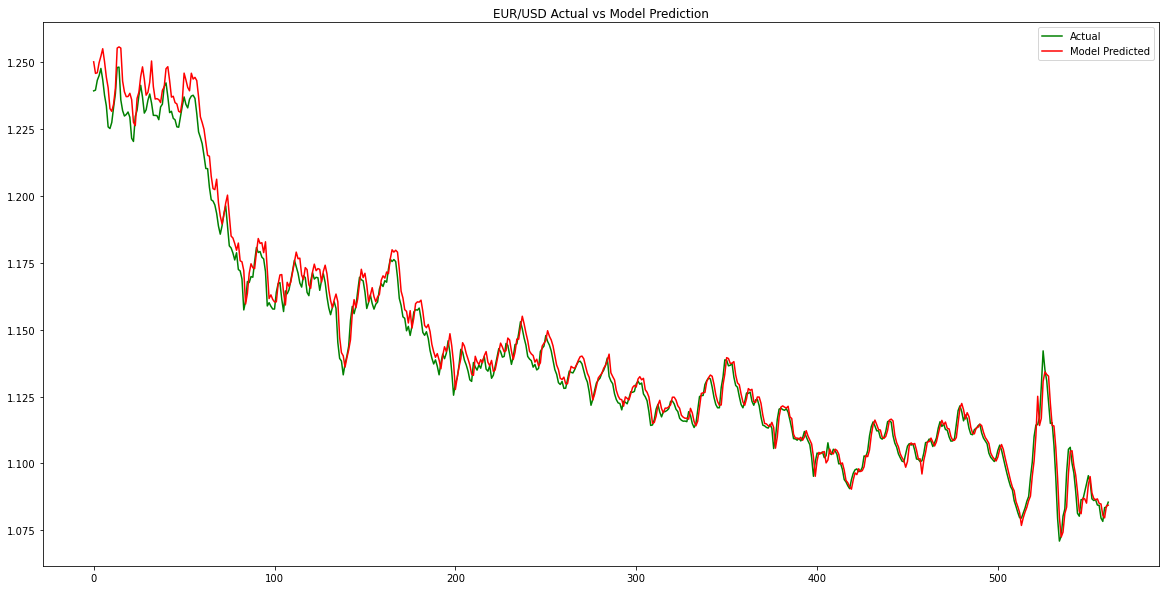

In [31]:
plt.figure(figsize=(20,10))
plt.title('EUR/USD Actual vs Model Prediction')
plt.plot(y_test , label = 'Actual', color = 'g')
plt.plot(y_pred , label = 'Model Predicted', color = 'r')
plt.legend()

In [32]:
from sklearn.metrics import r2_score

In [33]:
y_train

array([1.28633375, 1.29437375, 1.29511792, ..., 1.23513292, 1.24307583,
       1.24331792])

In [34]:
r2_score(y_test, y_pred)

0.9860240958006612

In [35]:
X_test.index

DatetimeIndex(['2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01',
               '2018-02-02', '2018-02-05', '2018-02-06', '2018-02-07',
               '2018-02-08', '2018-02-09',
               ...
               '2020-04-16', '2020-04-17', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-27',
               '2020-04-28', '2020-04-29'],
              dtype='datetime64[ns]', name='Date_Time', length=562, freq=None)

In [36]:
actual_df = pd.DataFrame(y_test, index=X_test.index)
actual_df.columns = ['actual']
actual_df.head()

,actual
Date_Time,
2018-01-29,1.239169
2018-01-30,1.239448
2018-01-31,1.243113
2018-02-01,1.244866
2018-02-02,1.247545


In [37]:
pred_df = pd.DataFrame(y_pred, index=X_test.index)
pred_df.columns = ['predicted']
pred_df.head()

,predicted
Date_Time,
2018-01-29,1.250013
2018-01-30,1.245694
2018-01-31,1.245913
2018-02-01,1.249688
2018-02-02,1.252122


In [38]:
final_df = actual_df.merge(pred_df, how='left', left_index=True, right_index=True)
final_df.head()

,actual,predicted
Date_Time,,
2018-01-29,1.239169,1.250013
2018-01-30,1.239448,1.245694
2018-01-31,1.243113,1.245913
2018-02-01,1.244866,1.249688
2018-02-02,1.247545,1.252122


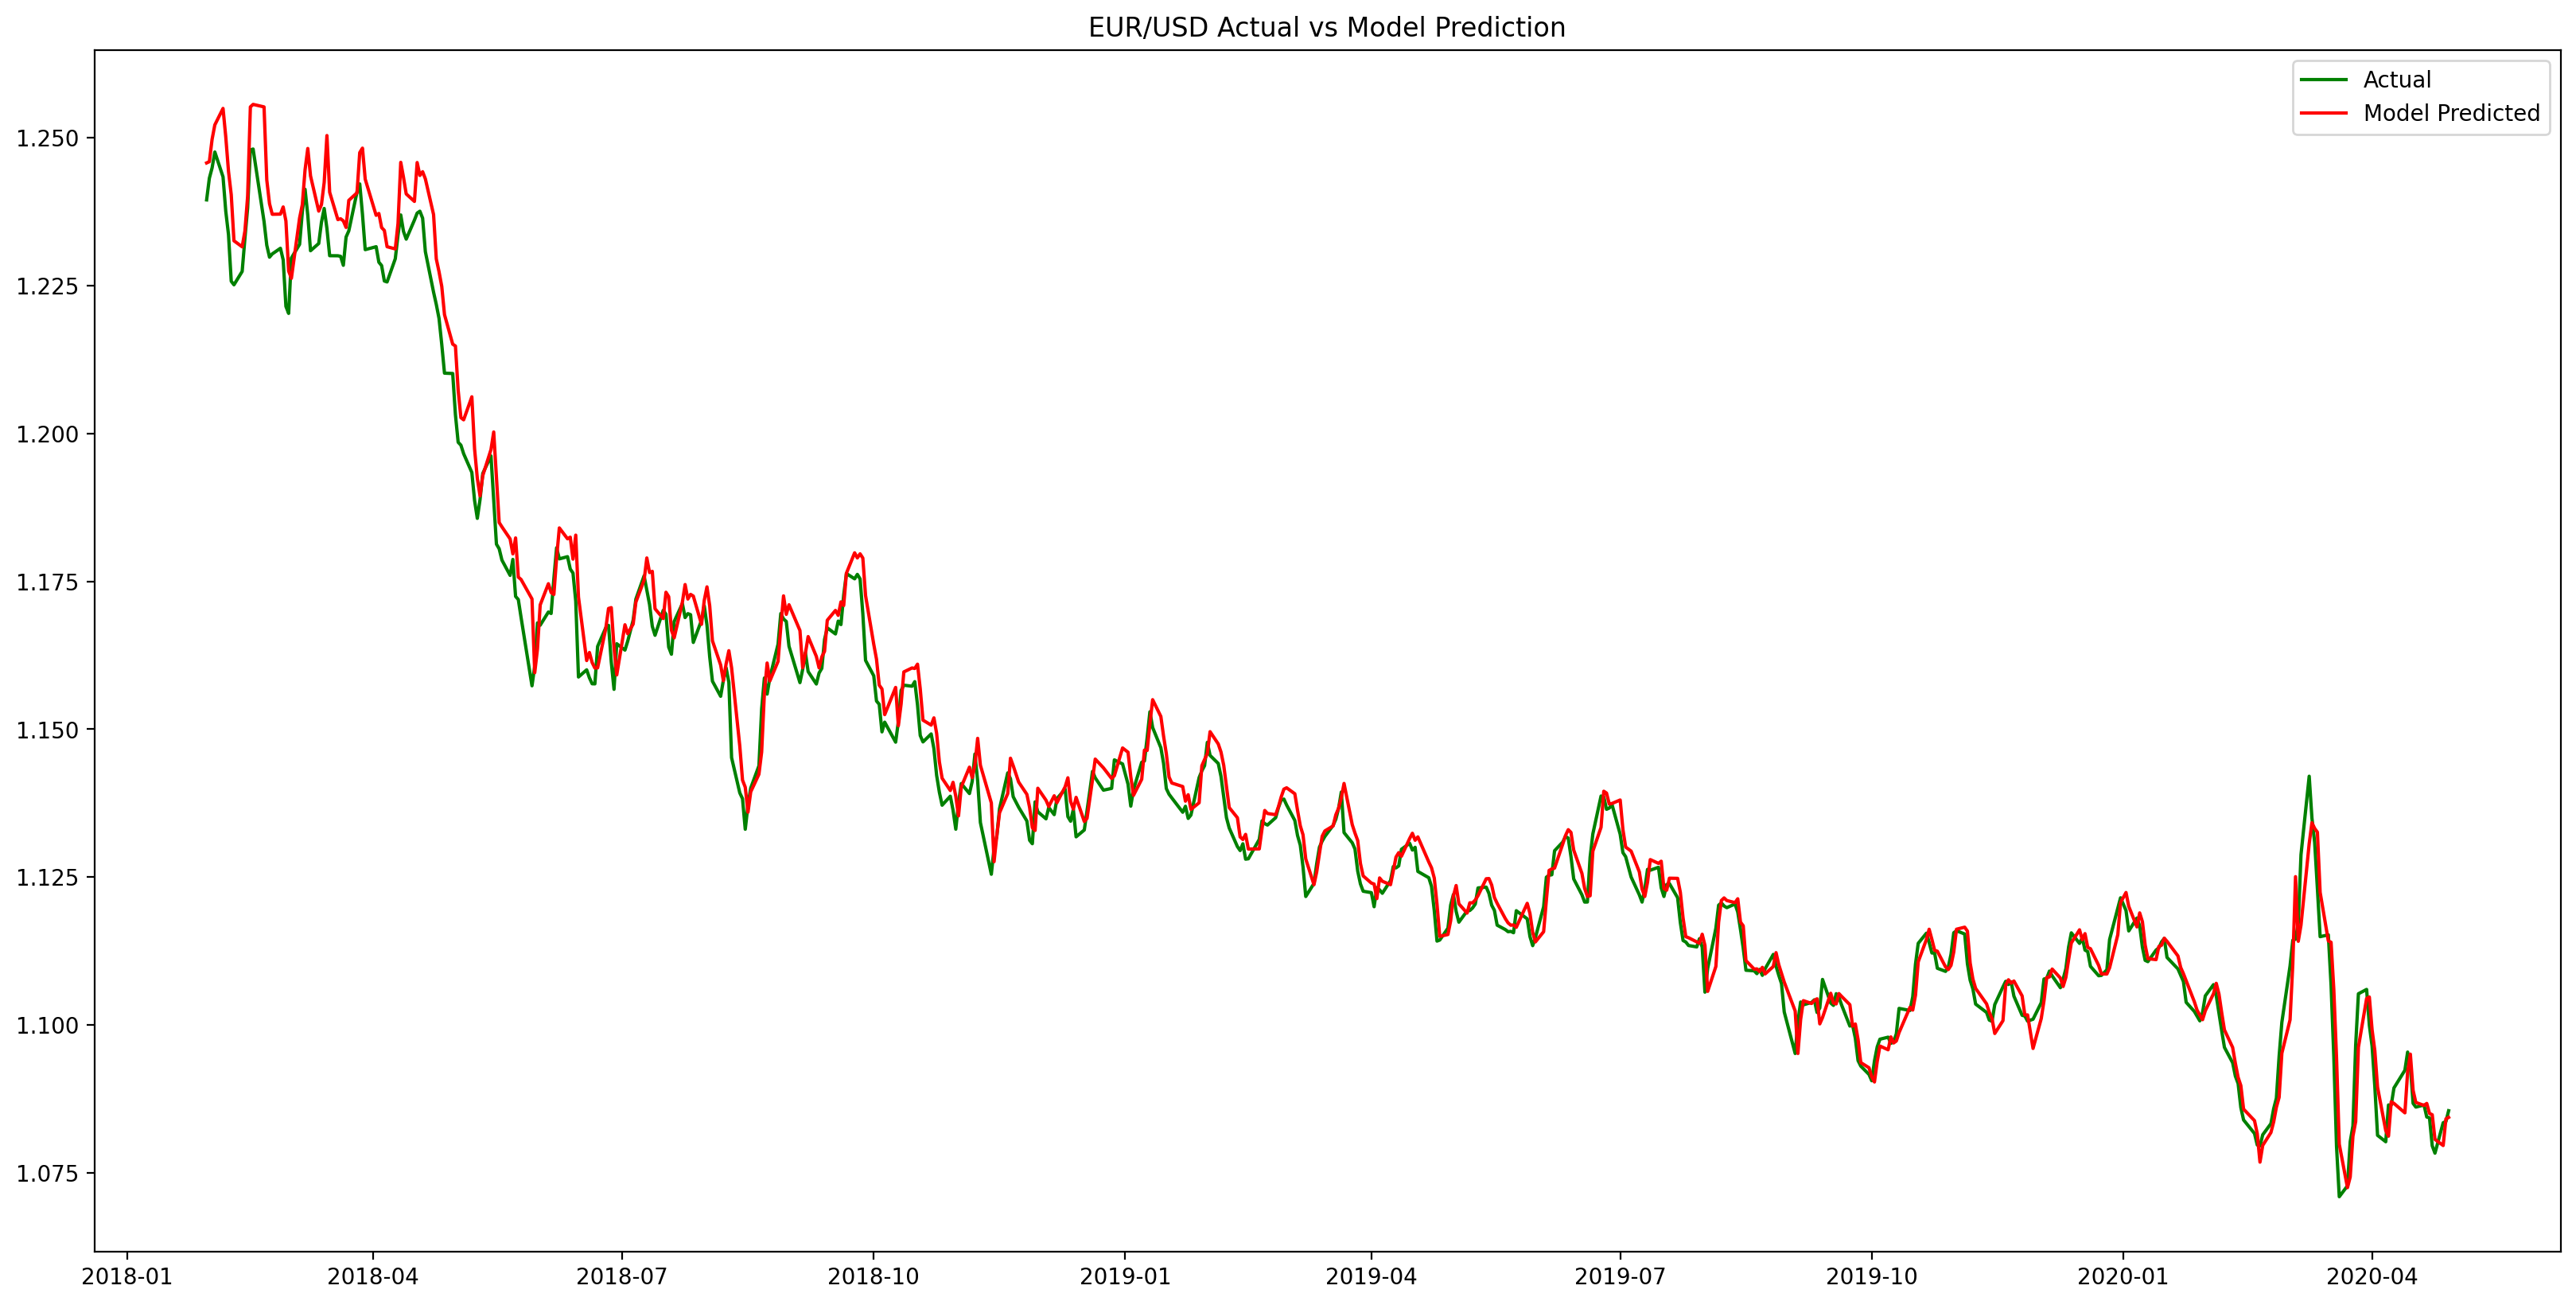

In [90]:
plt.figure(figsize=(20,10), dpi=200)
plt.title('EUR/USD Actual vs Model Prediction')
plt.plot(final_df['actual'], label = 'Actual', color = 'g')
plt.plot(final_df['predicted'], label = 'Model Predicted', color = 'r')
plt.legend();
plt.savefig('../visualizations/test_data_model_no_bc_results.png', bbox_inches='tight')

In [40]:
final_df['previous_day_bo'] = final_df['actual'].shift()
final_df.dropna(inplace=True)
final_df.head()

,actual,predicted,previous_day_bo
Date_Time,,,
2018-01-30,1.239448,1.245694,1.239169
2018-01-31,1.243113,1.245913,1.239448
2018-02-01,1.244866,1.249688,1.243113
2018-02-02,1.247545,1.252122,1.244866
2018-02-05,1.243339,1.254905,1.247545


In [41]:
final_df['Long/Short'] = np.where(final_df['predicted'] > final_df['previous_day_bo'], 'Long', 'Short')
final_df.head()

,actual,predicted,previous_day_bo,Long/Short
Date_Time,,,,
2018-01-30,1.239448,1.245694,1.239169,Long
2018-01-31,1.243113,1.245913,1.239448,Long
2018-02-01,1.244866,1.249688,1.243113,Long
2018-02-02,1.247545,1.252122,1.244866,Long
2018-02-05,1.243339,1.254905,1.247545,Long


In [42]:
final_df['Profit (pips)'] = np.where(final_df['Long/Short'] == 'Short', final_df['previous_day_bo'] - final_df['actual'], final_df['actual'] - final_df['previous_day_bo'])
final_df.head()

,actual,predicted,previous_day_bo,Long/Short,Profit (pips)
Date_Time,,,,,
2018-01-30,1.239448,1.245694,1.239169,Long,0.000279
2018-01-31,1.243113,1.245913,1.239448,Long,0.003665
2018-02-01,1.244866,1.249688,1.243113,Long,0.001753
2018-02-02,1.247545,1.252122,1.244866,Long,0.002679
2018-02-05,1.243339,1.254905,1.247545,Long,-0.004206


In [43]:
final_df['Profit (pips)'].sum() * 10000

94.97013768114738

In [44]:
final_df['Profit (pips)'].mean()

1.692872329432217e-05

In [45]:
final_df['Profit (pips)'].sort_values()

Date_Time
2018-06-15   -0.012835
2018-08-10   -0.012738
2018-02-20   -0.012250
2018-05-29   -0.011568
2020-03-06   -0.011563
                ...   
2018-02-15    0.009780
2020-03-18    0.012048
2020-03-09    0.013263
2020-03-26    0.013640
2020-03-19    0.015245
Name: Profit (pips), Length: 561, dtype: float64

In [88]:
from keras.models import load_model

In [89]:
model1.save('my_model_no_bc.h5')

# Below is model check to see how well it performs with unseen future data

In [46]:
df = pd.read_csv('../data/eurusd_hour_test_data.csv')
df.head()

,Date,Open,High,Low,Close
0,5/1/2020,1.0953,1.1017,1.0935,1.0980
1,5/4/2020,1.1094,1.1094,1.0896,1.0904
2,5/5/2020,1.0906,1.0926,1.0825,1.0837
3,5/6/2020,1.0838,1.0848,1.0782,1.0795
4,5/7/2020,1.0796,1.0836,1.0767,1.0835


In [47]:
df['Date'] = pd.to_datetime(df['Date'])

In [48]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close
Date,,,,
2020-05-01,1.0953,1.1017,1.0935,1.0980
2020-05-04,1.1094,1.1094,1.0896,1.0904
2020-05-05,1.0906,1.0926,1.0825,1.0837
2020-05-06,1.0838,1.0848,1.0782,1.0795
2020-05-07,1.0796,1.0836,1.0767,1.0835


In [49]:
df1 = pd.read_csv('../data/Financial Data USDEUR with 2020&2021.csv')
df1.head()

,Date_Time,federal funds rate,retail sales,core retail sales,PPI m/m,unemployment rate,main refinancing rate,CPI m/m,Core CPI m/m,Prelim GDP q/q
0,5/2/2005,0,0,0,0,0,0,0,0,0
1,5/3/2005,0,0,0,0,0,0,0,0,0
2,5/4/2005,0,0,0,0,0,0,0,0,0
3,5/5/2005,0,0,0,0,0,0,0,0,0
4,5/6/2005,0,0,0,0,0,0,0,0,0


In [50]:
df1['Date_Time'] = pd.to_datetime(df1['Date_Time'])
df1.set_index('Date_Time', inplace=True)
df1.head()

,federal funds rate,retail sales,core retail sales,PPI m/m,unemployment rate,main refinancing rate,CPI m/m,Core CPI m/m,Prelim GDP q/q
Date_Time,,,,,,,,,
2005-05-02,0,0,0,0,0,0,0,0,0
2005-05-03,0,0,0,0,0,0,0,0,0
2005-05-04,0,0,0,0,0,0,0,0,0
2005-05-05,0,0,0,0,0,0,0,0,0
2005-05-06,0,0,0,0,0,0,0,0,0


In [51]:
df2 = pd.read_csv('../data/DailyTreasuryYieldCurveRateData2021.csv')
df2.head()

,Date,1 mo,3 mo,6 mo,1 yr,2 yr,3 yr,5 yr,7 yr,10 yr,20 yr
0,5/1/2020,0.10,0.12,0.12,0.17,0.20,0.25,0.36,0.53,0.64,1.04
1,5/4/2020,0.10,0.13,0.14,0.16,0.19,0.24,0.36,0.52,0.64,1.05
2,5/5/2020,0.09,0.13,0.15,0.16,0.19,0.24,0.36,0.53,0.66,1.07
3,5/6/2020,0.08,0.12,0.16,0.16,0.17,0.24,0.37,0.57,0.72,1.16
4,5/7/2020,0.10,0.11,0.14,0.15,0.13,0.19,0.29,0.49,0.63,1.05


In [52]:
df2['Date'] = pd.to_datetime(df2['Date'])
df2.set_index('Date', inplace=True)
df2.head()

,1 mo,3 mo,6 mo,1 yr,2 yr,3 yr,5 yr,7 yr,10 yr,20 yr
Date,,,,,,,,,,
2020-05-01,0.10,0.12,0.12,0.17,0.20,0.25,0.36,0.53,0.64,1.04
2020-05-04,0.10,0.13,0.14,0.16,0.19,0.24,0.36,0.52,0.64,1.05
2020-05-05,0.09,0.13,0.15,0.16,0.19,0.24,0.36,0.53,0.66,1.07
2020-05-06,0.08,0.12,0.16,0.16,0.17,0.24,0.37,0.57,0.72,1.16
2020-05-07,0.10,0.11,0.14,0.15,0.13,0.19,0.29,0.49,0.63,1.05


In [53]:
df_1_merge = df.merge(df2, how='left', left_index=True, right_index=True)
df_1_merge.head()

,Open,High,Low,Close,1 mo,3 mo,6 mo,1 yr,2 yr,3 yr,5 yr,7 yr,10 yr,20 yr
Date,,,,,,,,,,,,,,
2020-05-01,1.0953,1.1017,1.0935,1.0980,0.10,0.12,0.12,0.17,0.20,0.25,0.36,0.53,0.64,1.04
2020-05-04,1.1094,1.1094,1.0896,1.0904,0.10,0.13,0.14,0.16,0.19,0.24,0.36,0.52,0.64,1.05
2020-05-05,1.0906,1.0926,1.0825,1.0837,0.09,0.13,0.15,0.16,0.19,0.24,0.36,0.53,0.66,1.07
2020-05-06,1.0838,1.0848,1.0782,1.0795,0.08,0.12,0.16,0.16,0.17,0.24,0.37,0.57,0.72,1.16
2020-05-07,1.0796,1.0836,1.0767,1.0835,0.10,0.11,0.14,0.15,0.13,0.19,0.29,0.49,0.63,1.05


In [54]:
df_2_merge = df_1_merge.merge(df1, how='left', left_index=True, right_index=True)
df_2_merge.head()

,Open,High,Low,Close,1 mo,3 mo,6 mo,1 yr,2 yr,3 yr,...,20 yr,federal funds rate,retail sales,core retail sales,PPI m/m,unemployment rate,main refinancing rate,CPI m/m,Core CPI m/m,Prelim GDP q/q
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,1.0953,1.1017,1.0935,1.0980,0.10,0.12,0.12,0.17,0.20,0.25,...,1.04,0,0,0,0,0,0,0,0,0
2020-05-04,1.1094,1.1094,1.0896,1.0904,0.10,0.13,0.14,0.16,0.19,0.24,...,1.05,0,0,0,0,0,0,0,0,0
2020-05-05,1.0906,1.0926,1.0825,1.0837,0.09,0.13,0.15,0.16,0.19,0.24,...,1.07,0,0,0,0,0,0,0,0,0
2020-05-06,1.0838,1.0848,1.0782,1.0795,0.08,0.12,0.16,0.16,0.17,0.24,...,1.16,0,0,0,0,0,0,0,0,0
2020-05-07,1.0796,1.0836,1.0767,1.0835,0.10,0.11,0.14,0.15,0.13,0.19,...,1.05,0,0,0,0,0,0,0,0,0


In [55]:
df_2_merge.isna().sum()

 Open                     0
 High                     0
 Low                      0
 Close                    0
1 mo                     17
3 mo                     17
6 mo                     17
1 yr                     17
2 yr                     17
3 yr                     17
5 yr                     17
7 yr                     17
10 yr                    17
20 yr                    17
federal funds rate        0
retail sales              0
core retail sales         0
PPI m/m                   0
unemployment rate         0
main refinancing rate     0
CPI m/m                   0
Core CPI m/m              0
Prelim GDP q/q            0
dtype: int64

In [56]:
df_2_merge.dropna(inplace=True)

In [57]:
df_2_merge.isna().sum()

 Open                    0
 High                    0
 Low                     0
 Close                   0
1 mo                     0
3 mo                     0
6 mo                     0
1 yr                     0
2 yr                     0
3 yr                     0
5 yr                     0
7 yr                     0
10 yr                    0
20 yr                    0
federal funds rate       0
retail sales             0
core retail sales        0
PPI m/m                  0
unemployment rate        0
main refinancing rate    0
CPI m/m                  0
Core CPI m/m             0
Prelim GDP q/q           0
dtype: int64

In [58]:
df_2_merge.head()

,Open,High,Low,Close,1 mo,3 mo,6 mo,1 yr,2 yr,3 yr,...,20 yr,federal funds rate,retail sales,core retail sales,PPI m/m,unemployment rate,main refinancing rate,CPI m/m,Core CPI m/m,Prelim GDP q/q
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,1.0953,1.1017,1.0935,1.0980,0.10,0.12,0.12,0.17,0.20,0.25,...,1.04,0,0,0,0,0,0,0,0,0
2020-05-04,1.1094,1.1094,1.0896,1.0904,0.10,0.13,0.14,0.16,0.19,0.24,...,1.05,0,0,0,0,0,0,0,0,0
2020-05-05,1.0906,1.0926,1.0825,1.0837,0.09,0.13,0.15,0.16,0.19,0.24,...,1.07,0,0,0,0,0,0,0,0,0
2020-05-06,1.0838,1.0848,1.0782,1.0795,0.08,0.12,0.16,0.16,0.17,0.24,...,1.16,0,0,0,0,0,0,0,0,0
2020-05-07,1.0796,1.0836,1.0767,1.0835,0.10,0.11,0.14,0.15,0.13,0.19,...,1.05,0,0,0,0,0,0,0,0,0


In [59]:
Bid_Open = df_2_merge[[' Open']]
Bid_Open.head()

,Open
Date,
2020-05-01,1.0953
2020-05-04,1.1094
2020-05-05,1.0906
2020-05-06,1.0838
2020-05-07,1.0796


In [60]:
df_shifted = df_2_merge.shift()
df_shifted.drop(columns=[' Open'], inplace=True)
df_shifted.head()

,High,Low,Close,1 mo,3 mo,6 mo,1 yr,2 yr,3 yr,5 yr,...,20 yr,federal funds rate,retail sales,core retail sales,PPI m/m,unemployment rate,main refinancing rate,CPI m/m,Core CPI m/m,Prelim GDP q/q
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-04,1.1017,1.0935,1.0980,0.10,0.12,0.12,0.17,0.20,0.25,0.36,...,1.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-05,1.1094,1.0896,1.0904,0.10,0.13,0.14,0.16,0.19,0.24,0.36,...,1.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-06,1.0926,1.0825,1.0837,0.09,0.13,0.15,0.16,0.19,0.24,0.36,...,1.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-07,1.0848,1.0782,1.0795,0.08,0.12,0.16,0.16,0.17,0.24,0.37,...,1.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
df_merged = Bid_Open.merge(df_shifted, how='left', left_index=True, right_index=True)
df_merged.head()

,Open,High,Low,Close,1 mo,3 mo,6 mo,1 yr,2 yr,3 yr,...,20 yr,federal funds rate,retail sales,core retail sales,PPI m/m,unemployment rate,main refinancing rate,CPI m/m,Core CPI m/m,Prelim GDP q/q
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,1.0953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-04,1.1094,1.1017,1.0935,1.0980,0.10,0.12,0.12,0.17,0.20,0.25,...,1.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-05,1.0906,1.1094,1.0896,1.0904,0.10,0.13,0.14,0.16,0.19,0.24,...,1.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-06,1.0838,1.0926,1.0825,1.0837,0.09,0.13,0.15,0.16,0.19,0.24,...,1.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-07,1.0796,1.0848,1.0782,1.0795,0.08,0.12,0.16,0.16,0.17,0.24,...,1.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
df_merged = df_merged.dropna()
df_merged.head()

,Open,High,Low,Close,1 mo,3 mo,6 mo,1 yr,2 yr,3 yr,...,20 yr,federal funds rate,retail sales,core retail sales,PPI m/m,unemployment rate,main refinancing rate,CPI m/m,Core CPI m/m,Prelim GDP q/q
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-04,1.1094,1.1017,1.0935,1.0980,0.10,0.12,0.12,0.17,0.20,0.25,...,1.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-05,1.0906,1.1094,1.0896,1.0904,0.10,0.13,0.14,0.16,0.19,0.24,...,1.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-06,1.0838,1.0926,1.0825,1.0837,0.09,0.13,0.15,0.16,0.19,0.24,...,1.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-07,1.0796,1.0848,1.0782,1.0795,0.08,0.12,0.16,0.16,0.17,0.24,...,1.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-08,1.0833,1.0836,1.0767,1.0835,0.10,0.11,0.14,0.15,0.13,0.19,...,1.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
df_merged = df_merged.drop(columns=[' Close'])

In [69]:
df_merged.shape

(418, 22)

In [70]:
X = df_merged.drop(columns=' Open')
y = df_merged[' Open'].values

In [71]:
X.head(2)

,High,Low,1 mo,3 mo,6 mo,1 yr,2 yr,3 yr,5 yr,7 yr,...,20 yr,federal funds rate,retail sales,core retail sales,PPI m/m,unemployment rate,main refinancing rate,CPI m/m,Core CPI m/m,Prelim GDP q/q
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-04,1.1017,1.0935,0.1,0.12,0.12,0.17,0.20,0.25,0.36,0.53,...,1.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-05,1.1094,1.0896,0.1,0.13,0.14,0.16,0.19,0.24,0.36,0.52,...,1.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
X_sc = ss.transform(X)

In [73]:
y_pred = model1.predict(X_sc)
y_pred[:10]

array([[1.096806 ],
       [1.0982525],
       [1.0874798],
       [1.0821967],
       [1.0810263],
       [1.0802099],
       [1.0881262],
       [1.0838332],
       [1.0856731],
       [1.080998 ]], dtype=float32)

In [74]:
y = np.array(y).reshape(-1,1)

In [75]:
y_pred.shape, y.shape

((418, 1), (418, 1))

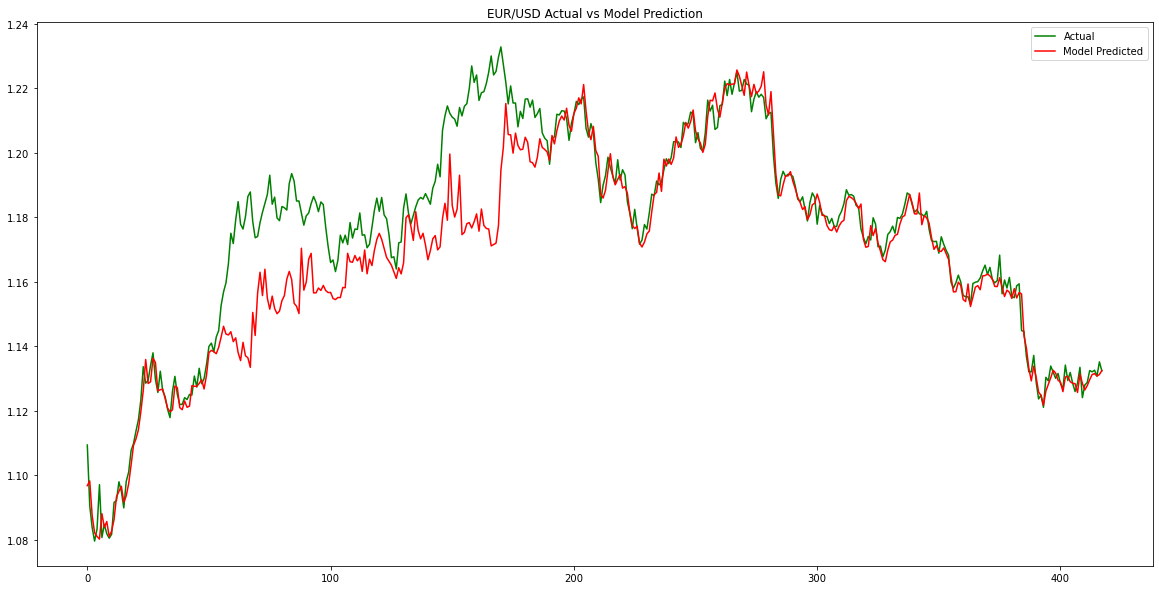

In [76]:
plt.figure(figsize=(20,10))
plt.title('EUR/USD Actual vs Model Prediction')
plt.plot(y , label = 'Actual', color = 'g')
plt.plot(y_pred , label = 'Model Predicted', color = 'r')
plt.legend();

In [77]:
r2_score(y, y_pred)

0.8039047222129765

In [78]:
future_actual_df = pd.DataFrame(y, index=X.index)
future_actual_df.columns = ['actual']
future_actual_df.head()

,actual
Date,
2020-05-04,1.1094
2020-05-05,1.0906
2020-05-06,1.0838
2020-05-07,1.0796
2020-05-08,1.0833


In [79]:
future_pred_df = pd.DataFrame(y_pred, index=X.index)
future_pred_df.columns = ['predicted']
future_pred_df.head()

,predicted
Date,
2020-05-04,1.096806
2020-05-05,1.098253
2020-05-06,1.087480
2020-05-07,1.082197
2020-05-08,1.081026


In [80]:
future_final_df = future_actual_df.merge(future_pred_df, how='left', left_index=True, right_index=True)
future_final_df.head()

,actual,predicted
Date,,
2020-05-04,1.1094,1.096806
2020-05-05,1.0906,1.098253
2020-05-06,1.0838,1.087480
2020-05-07,1.0796,1.082197
2020-05-08,1.0833,1.081026


In [81]:
future_final_df['previous_day_bo'] = future_final_df['actual'].shift()
future_final_df.dropna(inplace=True)
future_final_df.head()

,actual,predicted,previous_day_bo
Date,,,
2020-05-05,1.0906,1.098253,1.1094
2020-05-06,1.0838,1.087480,1.0906
2020-05-07,1.0796,1.082197,1.0838
2020-05-08,1.0833,1.081026,1.0796
2020-05-11,1.0971,1.080210,1.0833


In [82]:
future_final_df['Long/Short'] = np.where(future_final_df['predicted'] > future_final_df['previous_day_bo'], 'Long', 'Short')
future_final_df.head()

,actual,predicted,previous_day_bo,Long/Short
Date,,,,
2020-05-05,1.0906,1.098253,1.1094,Short
2020-05-06,1.0838,1.087480,1.0906,Short
2020-05-07,1.0796,1.082197,1.0838,Short
2020-05-08,1.0833,1.081026,1.0796,Long
2020-05-11,1.0971,1.080210,1.0833,Short


In [83]:
future_final_df['Profit (pips)'] = np.where(future_final_df['Long/Short'] == 'Short', future_final_df['previous_day_bo'] - future_final_df['actual'], future_final_df['actual'] - future_final_df['previous_day_bo'])
future_final_df.head()

,actual,predicted,previous_day_bo,Long/Short,Profit (pips)
Date,,,,,
2020-05-05,1.0906,1.098253,1.1094,Short,0.0188
2020-05-06,1.0838,1.087480,1.0906,Short,0.0068
2020-05-07,1.0796,1.082197,1.0838,Short,0.0042
2020-05-08,1.0833,1.081026,1.0796,Long,0.0037
2020-05-11,1.0971,1.080210,1.0833,Short,-0.0138


In [84]:
future_final_df['Profit (pips)'].sum() * 10000

6069.9999999999845

### Expected to net 6069 pips over the the data frame of profit

In [85]:
future_final_df['Profit (pips)'].mean()

0.001455635491606711

### 20.38 expected pips per trade

In [86]:
future_final_df['Profit (pips)'].sort_values()

Date
2020-12-02   -0.0144
2020-05-11   -0.0138
2020-11-06   -0.0105
2020-07-28   -0.0094
2021-07-14   -0.0083
               ...  
2021-11-01    0.0120
2021-06-17    0.0132
2021-11-12    0.0145
2020-05-12    0.0164
2020-05-05    0.0188
Name: Profit (pips), Length: 417, dtype: float64

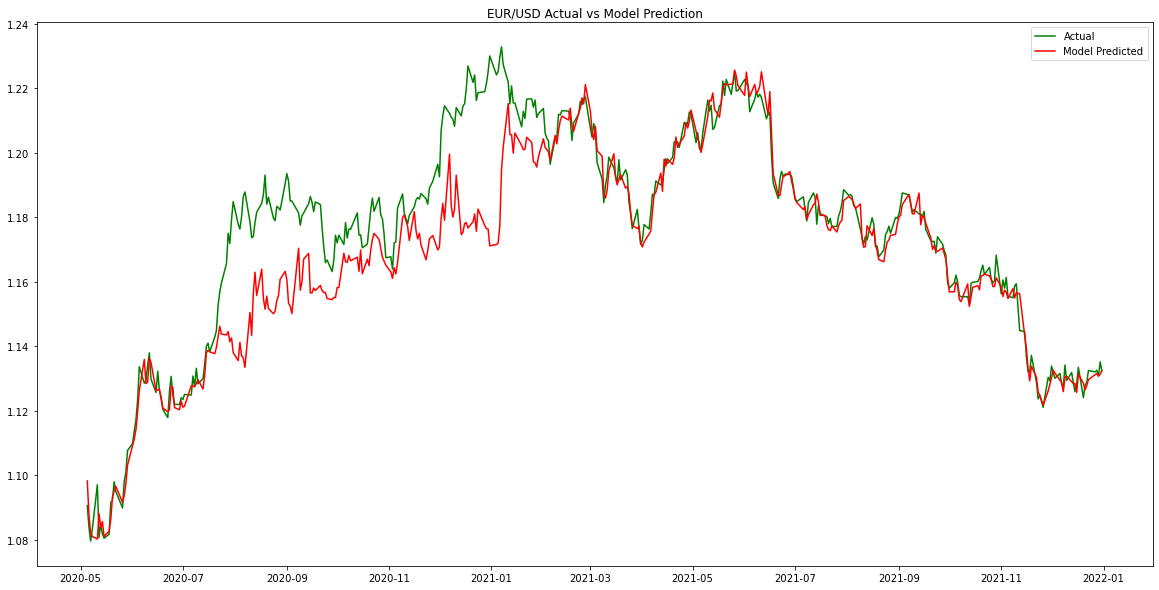

In [91]:
plt.figure(figsize=(20,10))
plt.title('EUR/USD Actual vs Model Prediction')
plt.plot(future_final_df['actual'] , label = 'Actual', color = 'g')
plt.plot(future_final_df['predicted'], label = 'Model Predicted', color = 'r')
plt.legend()
plt.savefig('../visualizations/unknown_data_model_no_bc_results.png', bbox_inches='tight')

In [78]:
#future_final_df.to_csv('../data/Unknown_data_model_results.csv')

In [79]:
pd.set_option('display.max_rows', 500)

In [80]:
future_final_df

,actual,predicted,previous_day_bo,Long/Short,Profit (pips)
Date,,,,,
2020-05-05,1.0906,1.095535,1.1094,Short,0.0188
2020-05-06,1.0838,1.085047,1.0906,Short,0.0068
2020-05-07,1.0796,1.079061,1.0838,Short,0.0042
2020-05-08,1.0833,1.079829,1.0796,Long,0.0037
2020-05-11,1.0971,1.083838,1.0833,Long,0.0138
2020-05-12,1.0807,1.083745,1.0971,Short,0.0164
2020-05-13,1.0848,1.082314,1.0807,Long,0.0041
2020-05-14,1.0819,1.082806,1.0848,Short,0.0029
2020-05-15,1.0805,1.079029,1.0819,Short,0.0014
